# Radar Water Level Monitoring

Here you can find some examples of data processing and plotting.

[data](https://o365coloradoedu-my.sharepoint.com/:f:/r/personal/chhe5305_colorado_edu/Documents/Radar%20Water%20Monitoring/RWM?csf=1&web=1&e=bF4kS6)

In [1]:
import datetime
import os
import pickle

import numpy as np
from tqdm import tqdm

from src import data_utils as utils, plots as plot

%matplotlib inline


data_file = os.path.expanduser('~/data/deployment_nov2023/processed_data.pkl')

## Load Data

In [2]:
with open(data_file, 'rb') as f:
    data = pickle.load(f)

dates, gt, awr1843, iwr1443 = data['dates'], data['ground_truth'], data['AWR1843'], data['IWR1443']
gt_dates, gt_depths = gt

In [3]:
len(dates), len(gt_dates), len(gt_depths)

(114, 746, 746)

In [4]:
awr1843.keys(), iwr1443.keys()

(dict_keys(['x', 'y', 'z', 'intensity']),
 dict_keys(['x', 'y', 'z', 'intensity']))

## Process Data

In [5]:
gt_dates_filtered, gt_depths_filtered = utils.filter_gt(gt_dates, gt_depths, min_depth_threshold=0.1)
print(len(gt_dates_filtered), len(gt_depths_filtered))

475 475


In [6]:
gt_depths_matched = utils.match_gt_to_timestamps(dates, gt_dates_filtered, gt_depths_filtered)
print(len(gt_depths_matched))

114


In [7]:
y_threshold=0.1
y_limit=10
x_limit=1
intensity_threshold_percent=50
window_size=20

In [8]:
awr1843_filtered = utils.filter_points(awr1843, y_threshold=y_threshold, y_limit=y_limit, x_limit=x_limit, intensity_threshold_percent=intensity_threshold_percent)

In [9]:
awr1843_stats = utils.compute_statistics(awr1843_filtered, window_size=window_size)

In [10]:
iwr1443_filtered = utils.filter_points(iwr1443, y_threshold=y_threshold, y_limit=y_limit, x_limit=x_limit, intensity_threshold_percent=intensity_threshold_percent)

In [11]:
iwr1443_stats = utils.compute_statistics(iwr1443_filtered, window_size=window_size)

## Plot Data

### AWR 1843

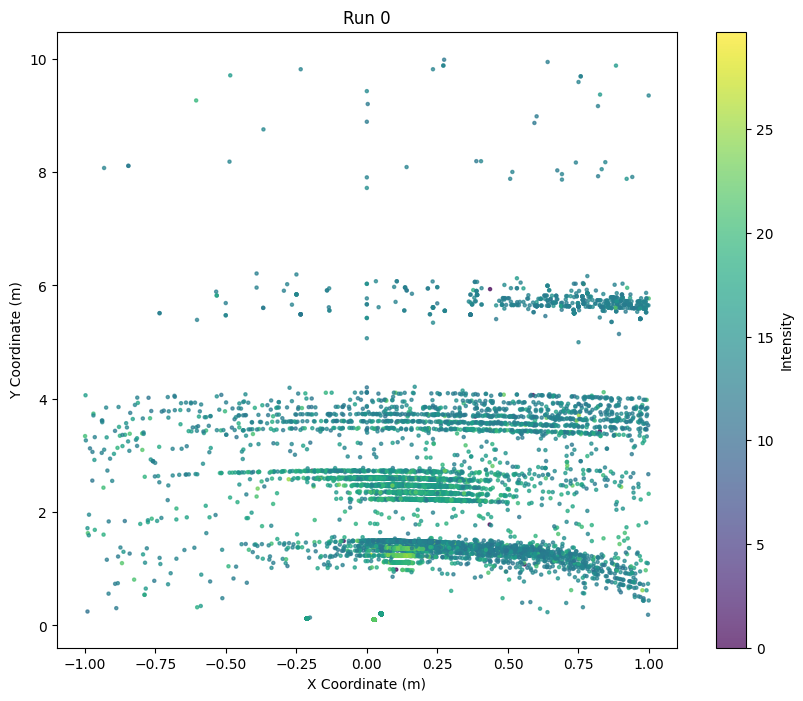

In [12]:
plot.points(awr1843_filtered, run_index=0)

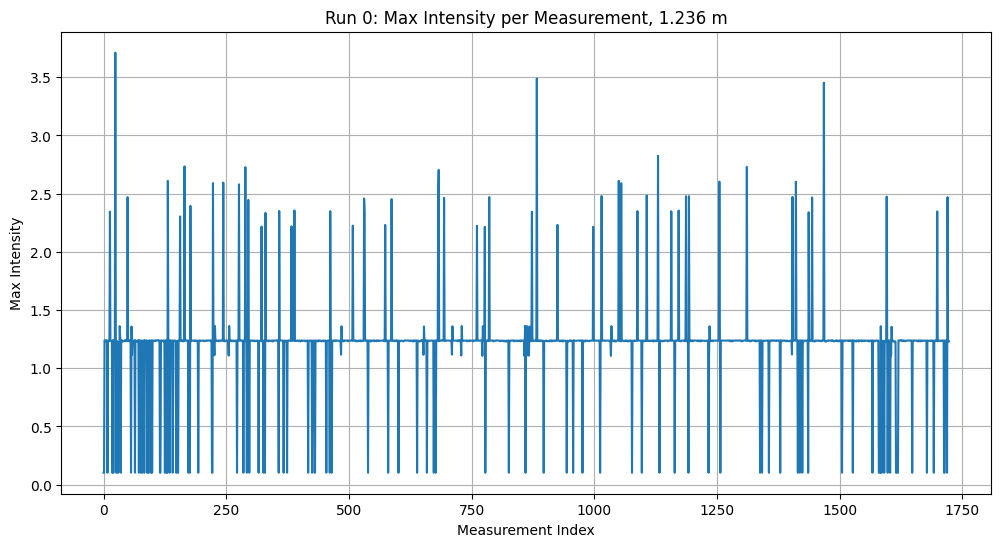

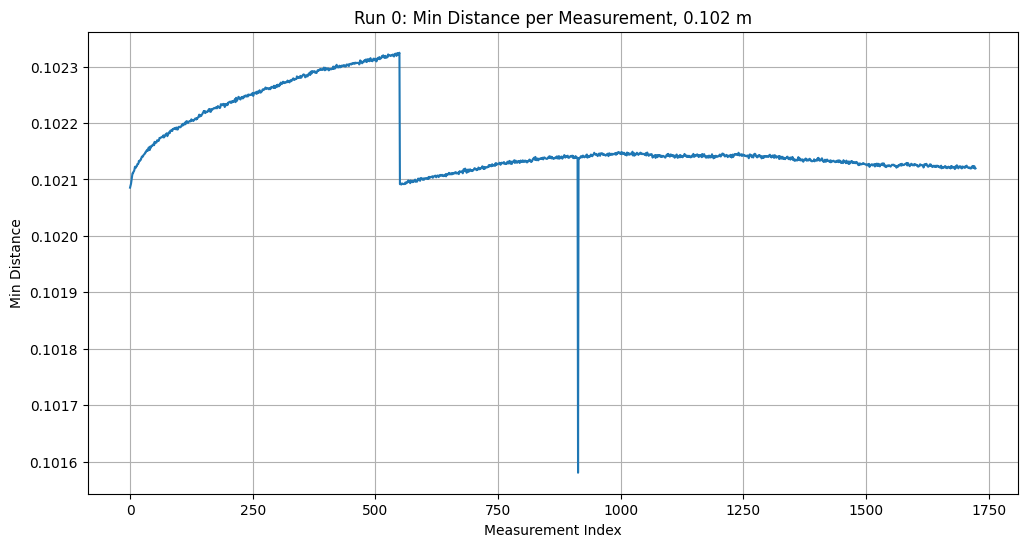

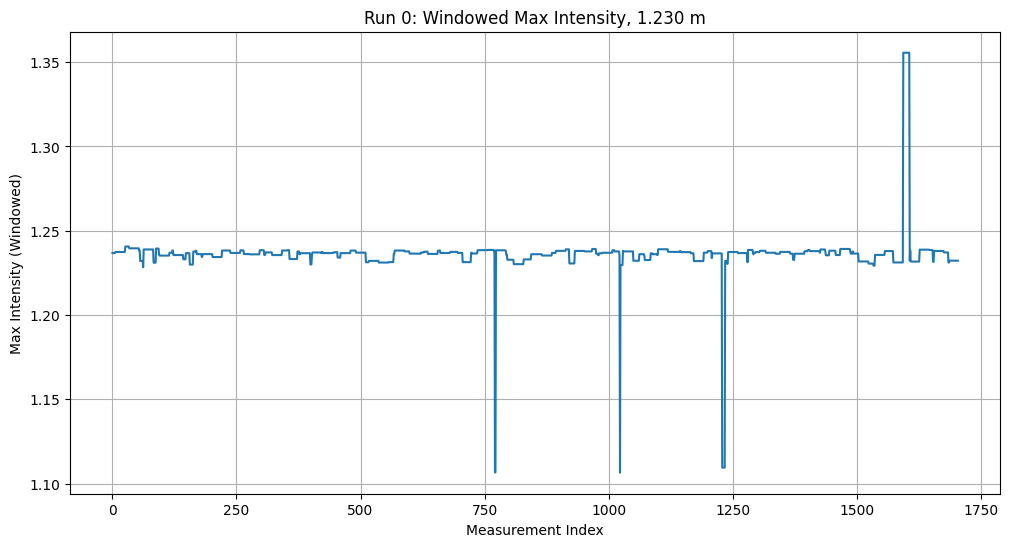

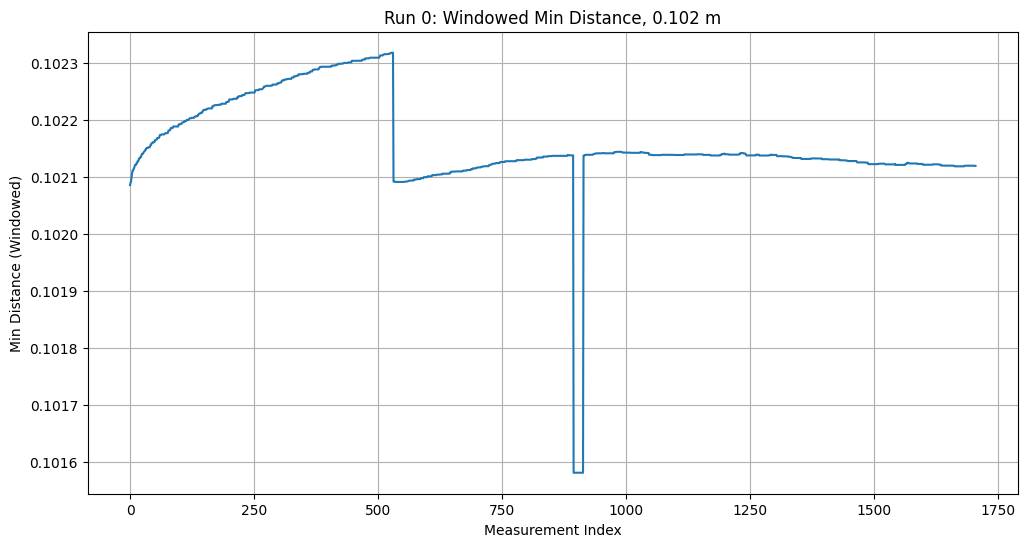

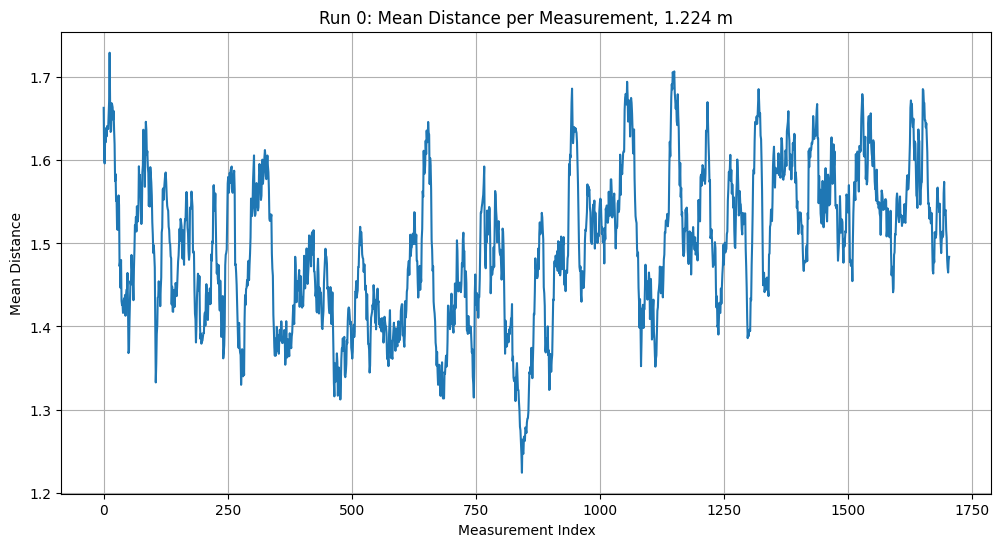

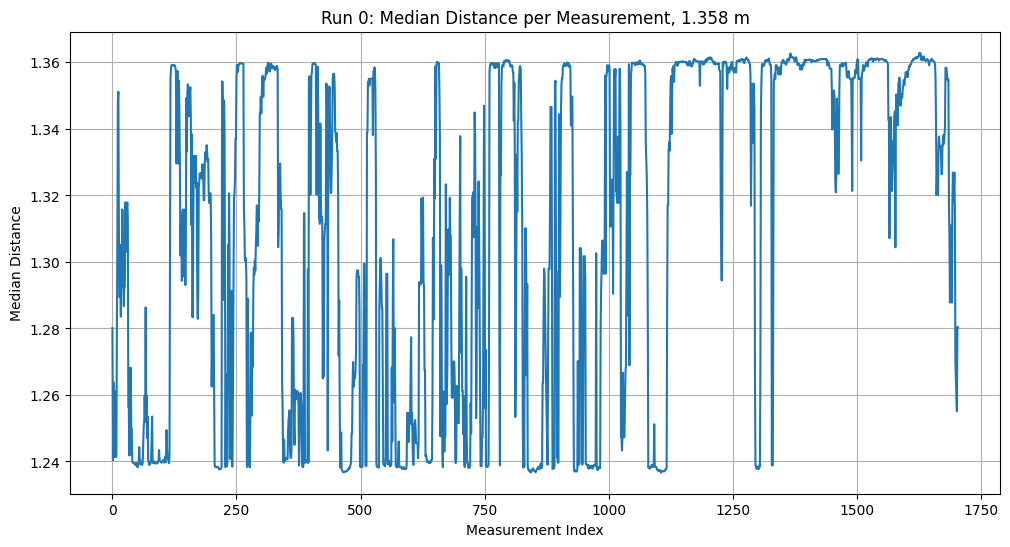

In [13]:
plot.stats(awr1843_stats, run_index=0)

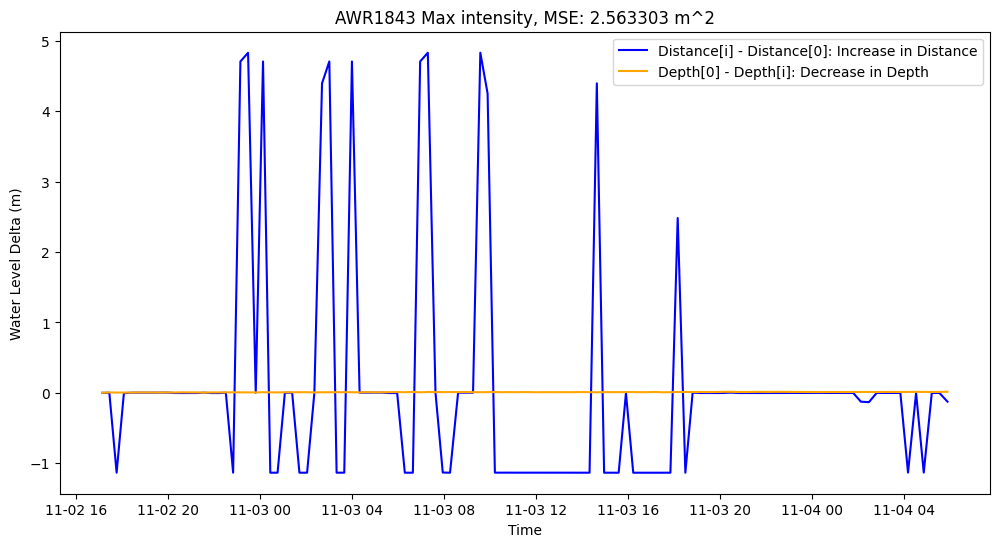

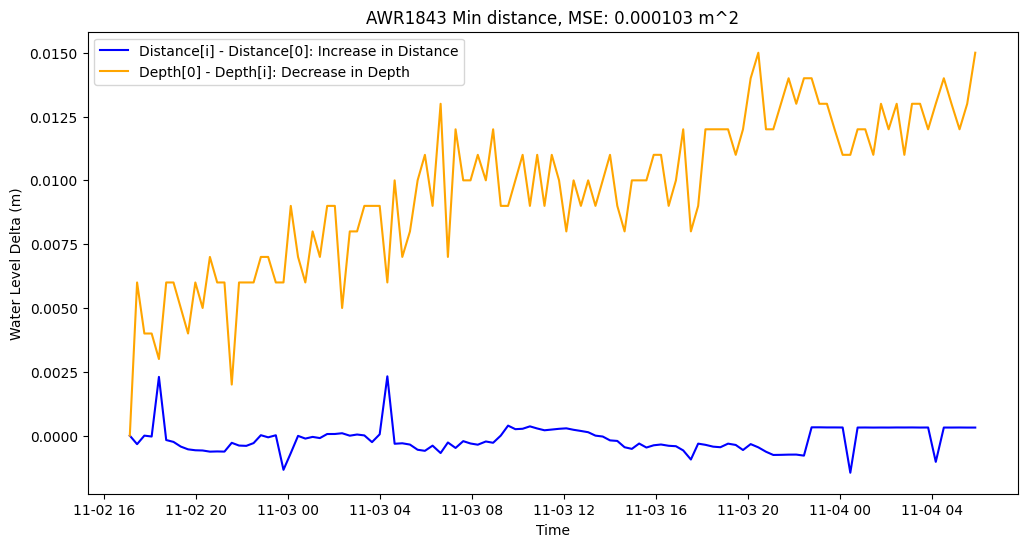

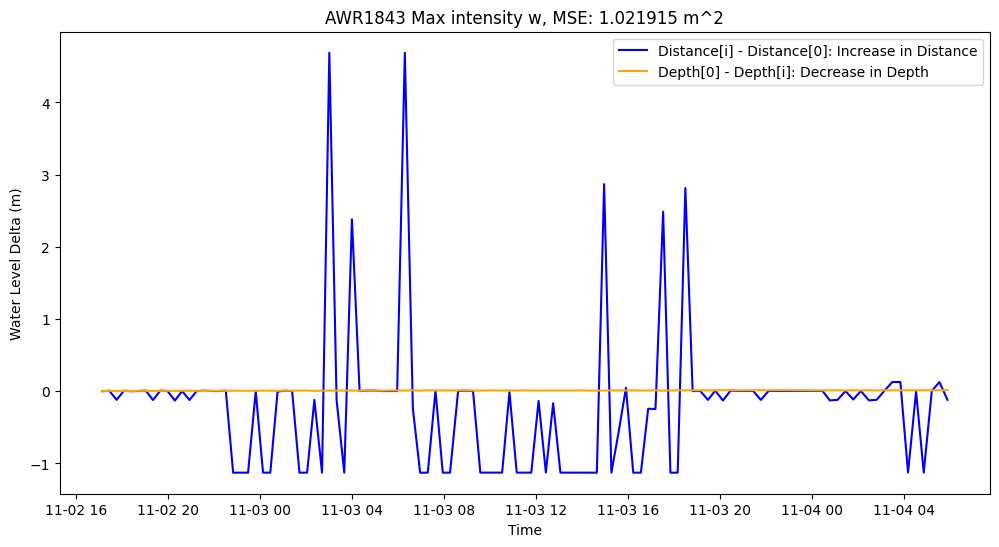

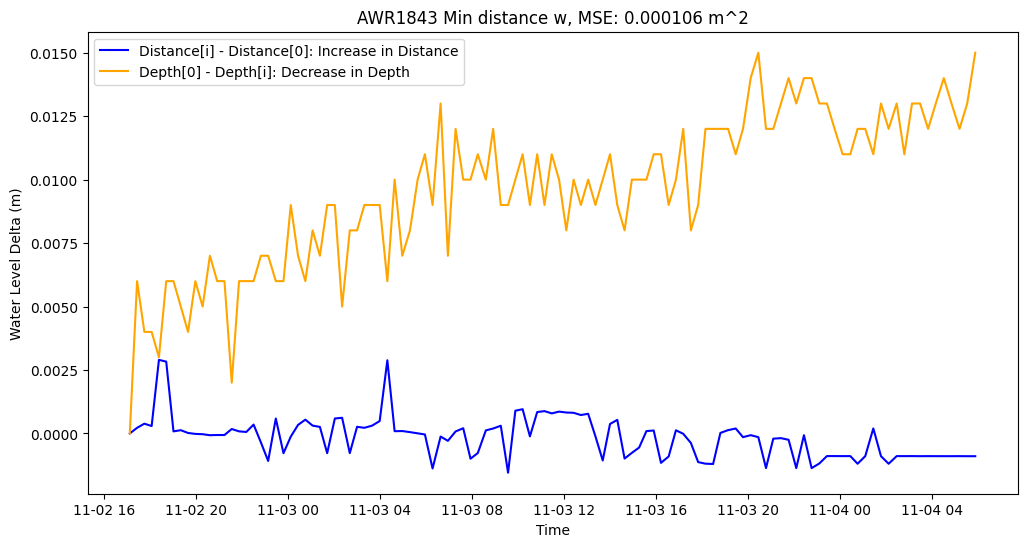

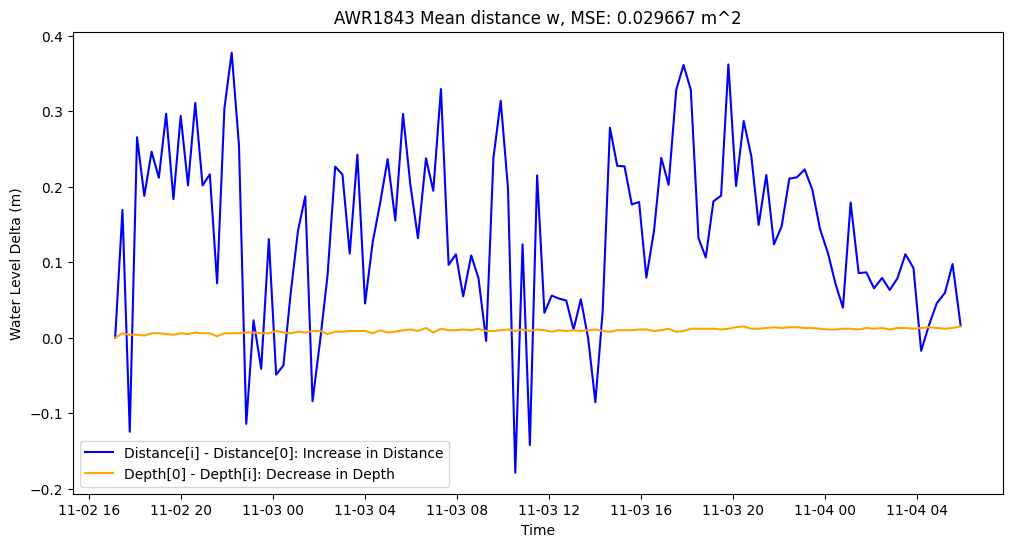

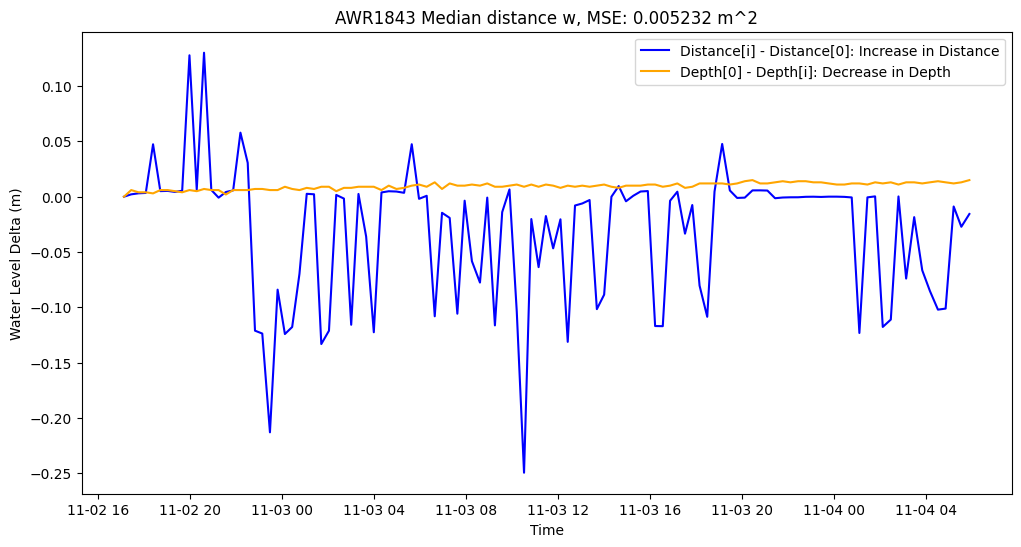

In [14]:
plot.deltas(dates, awr1843_stats, gt_depths_matched, sensor_name='awr1843')

### IWR 1443

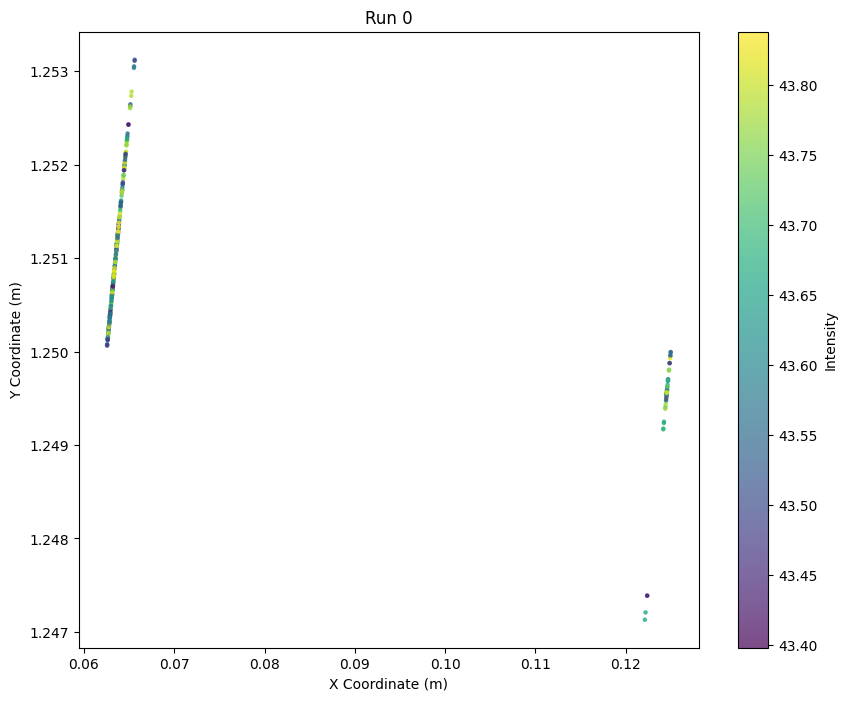

In [15]:
plot.points(iwr1443_filtered, run_index=0)

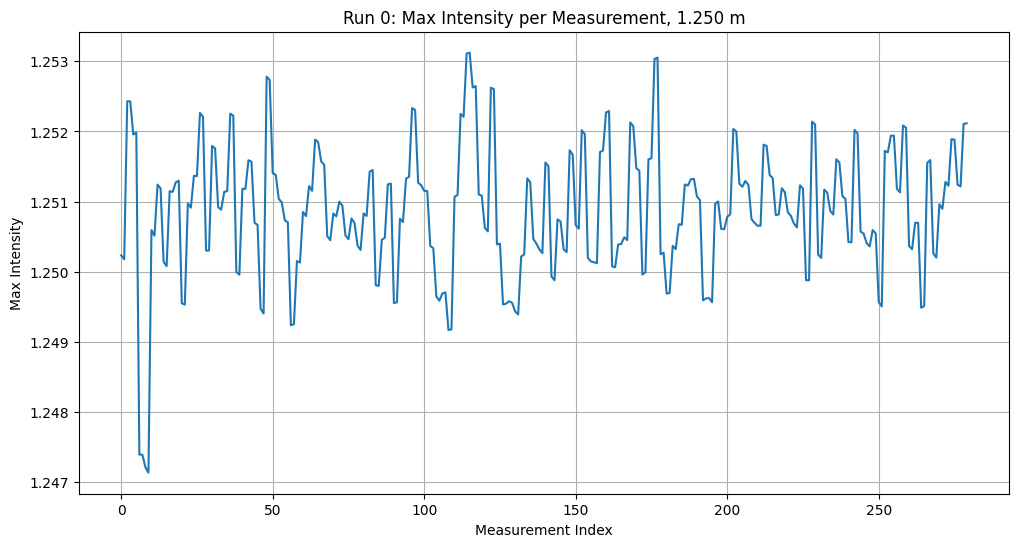

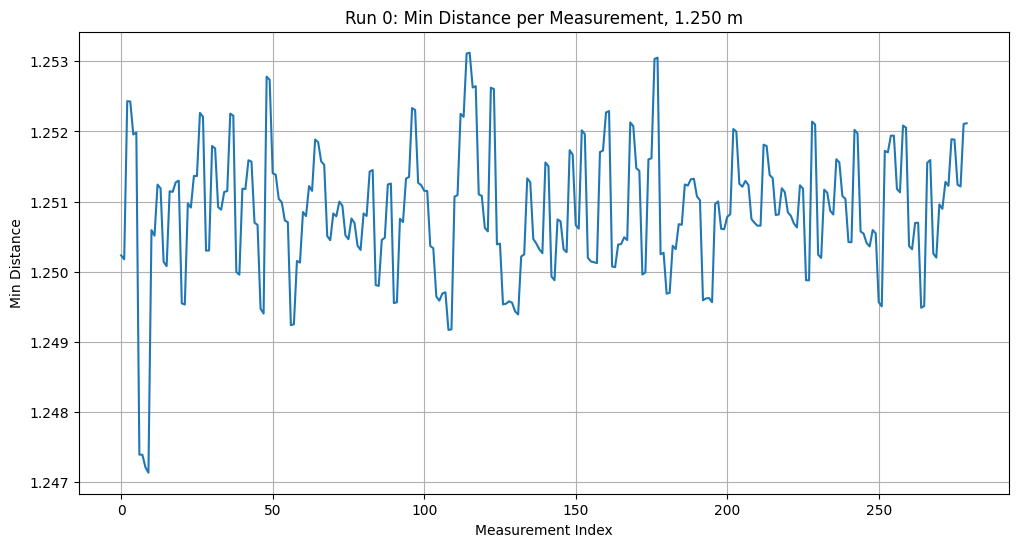

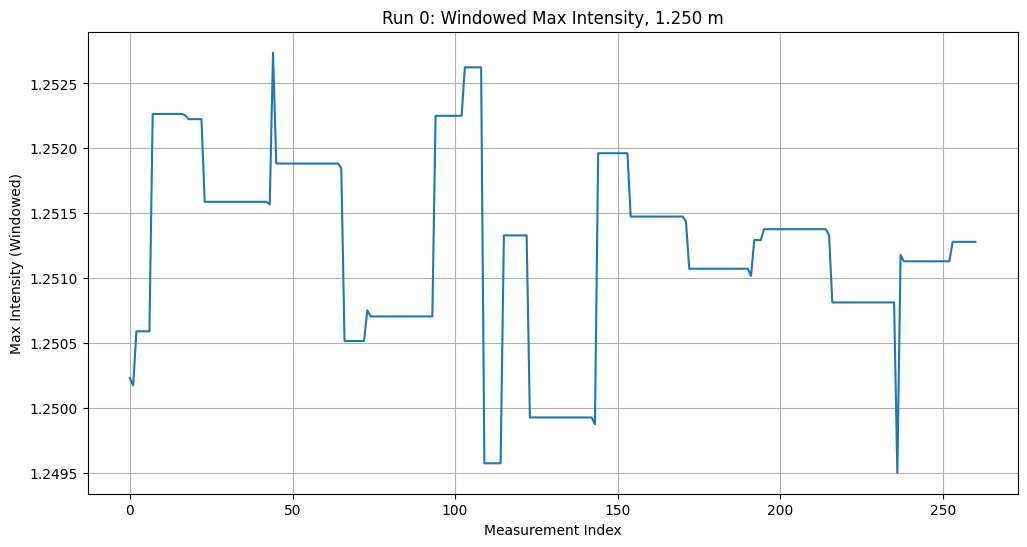

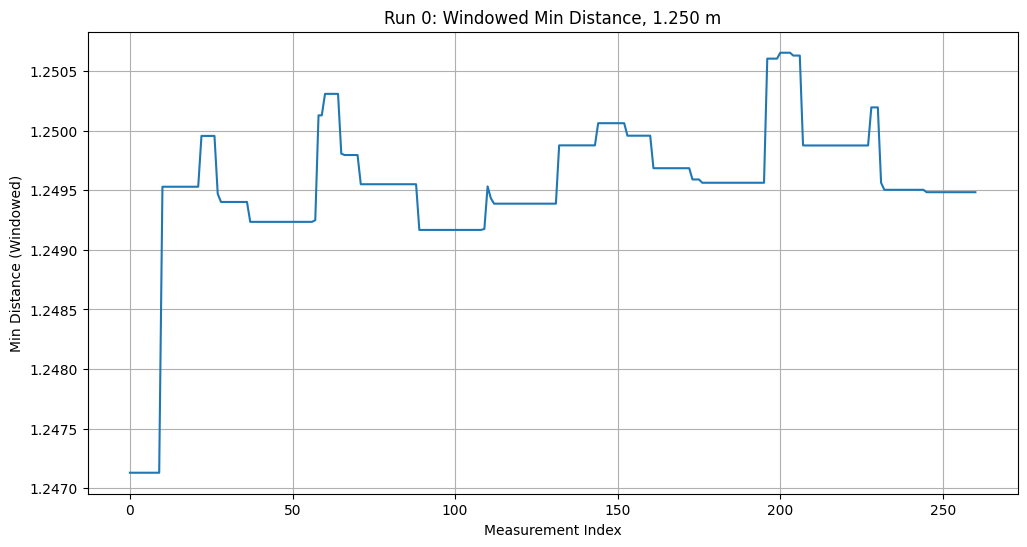

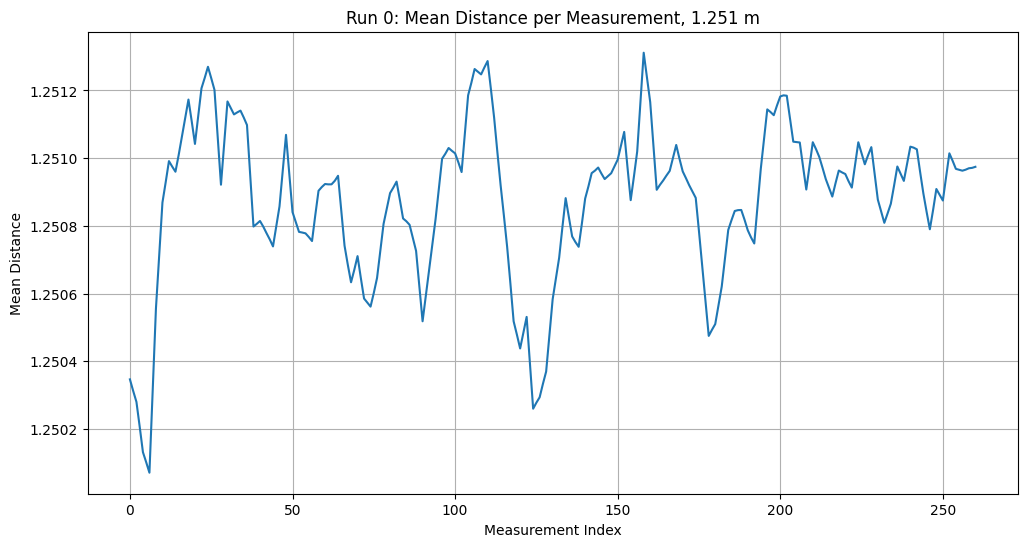

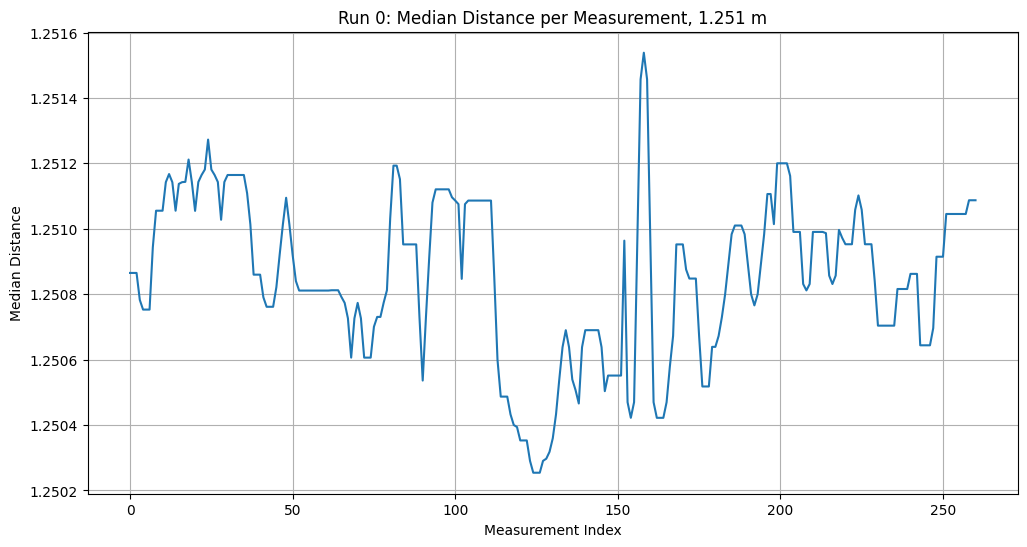

In [16]:
plot.stats(iwr1443_stats, run_index=0)

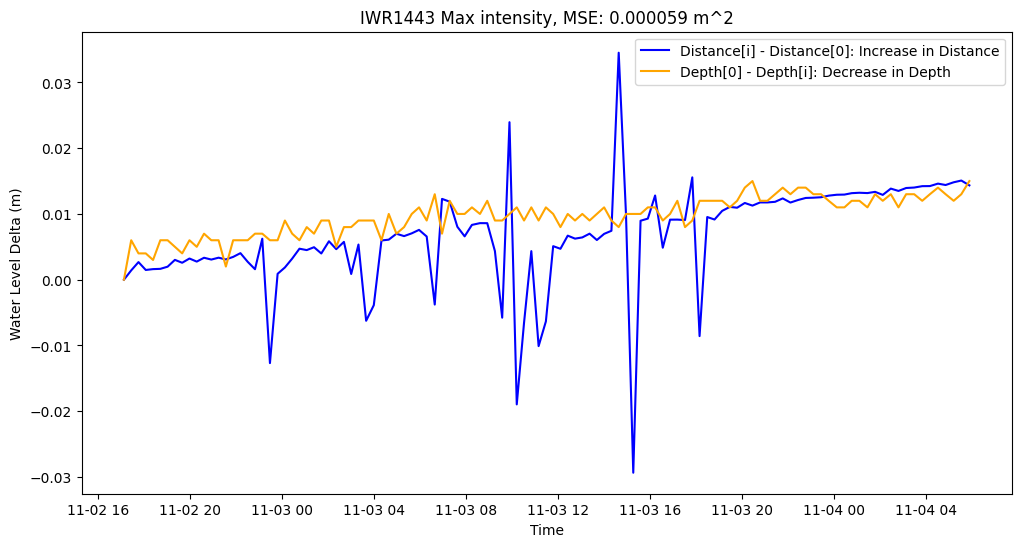

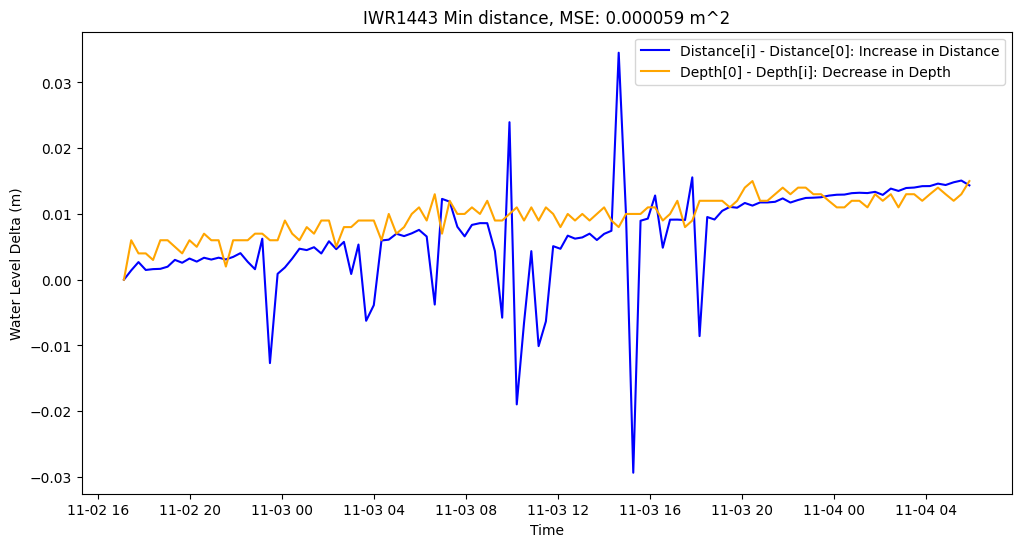

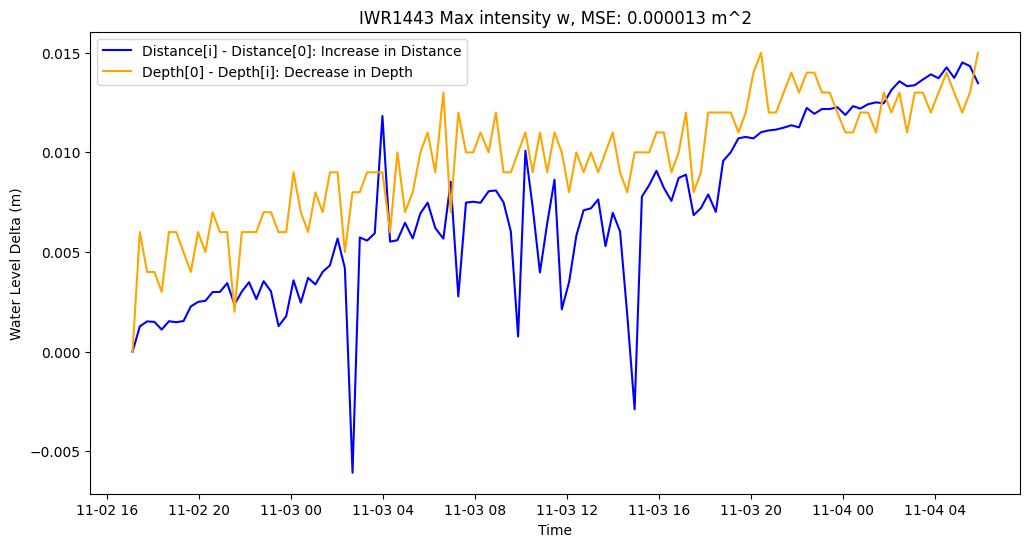

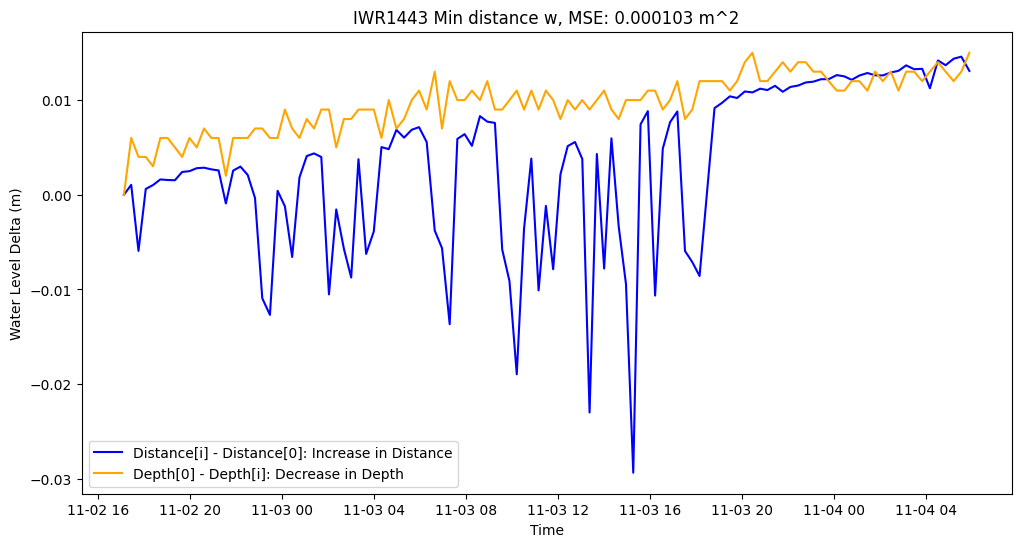

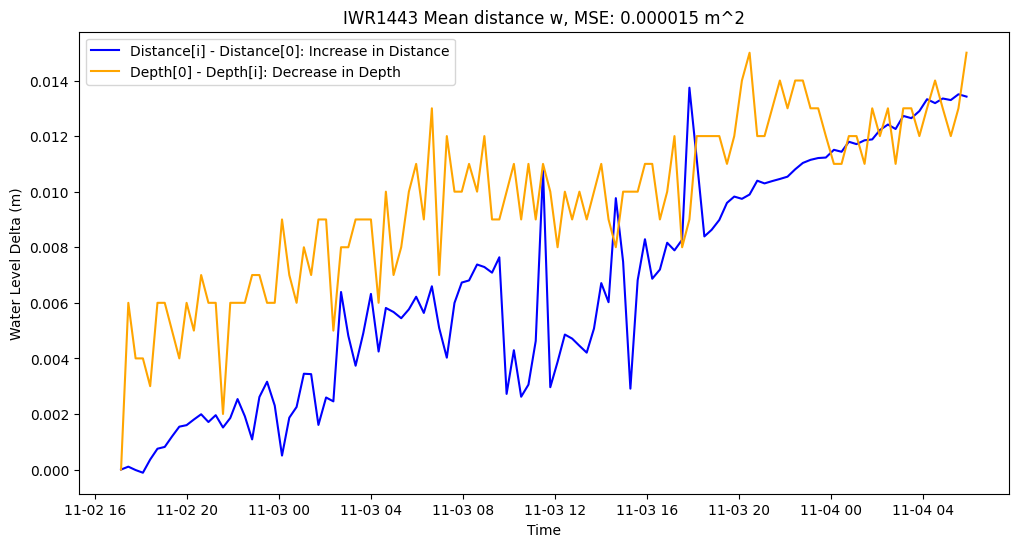

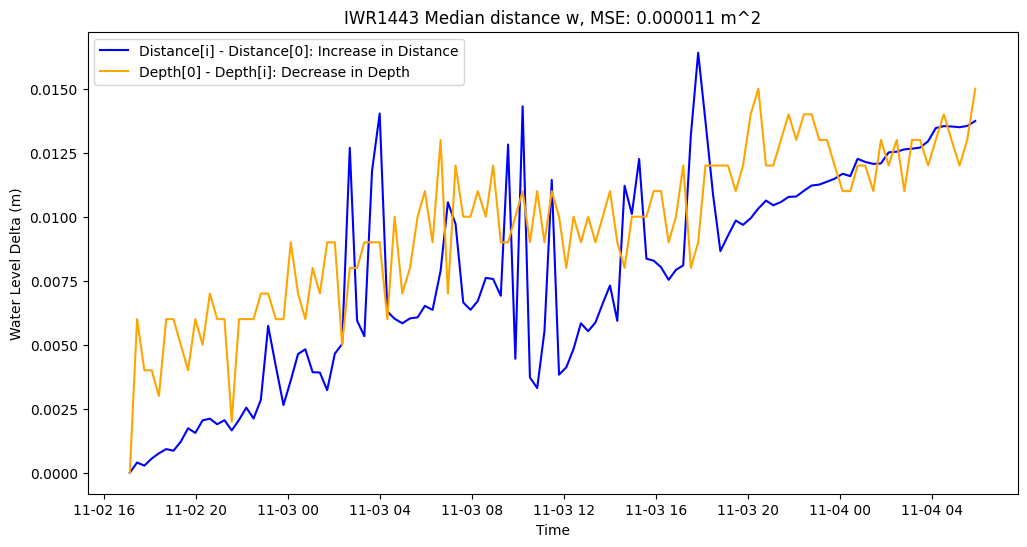

In [17]:
plot.deltas(dates, iwr1443_stats, gt_depths_matched, sensor_name='iwr1443')

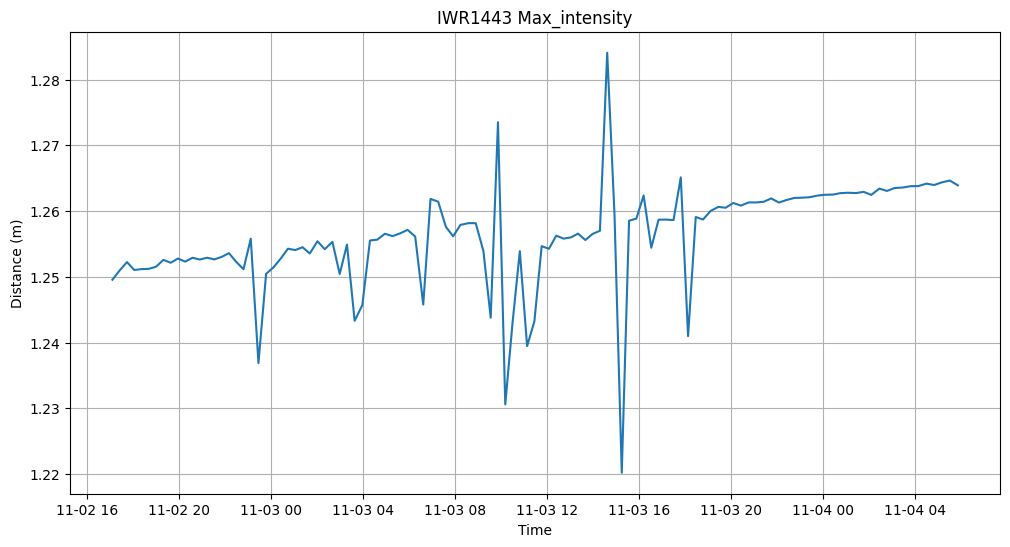

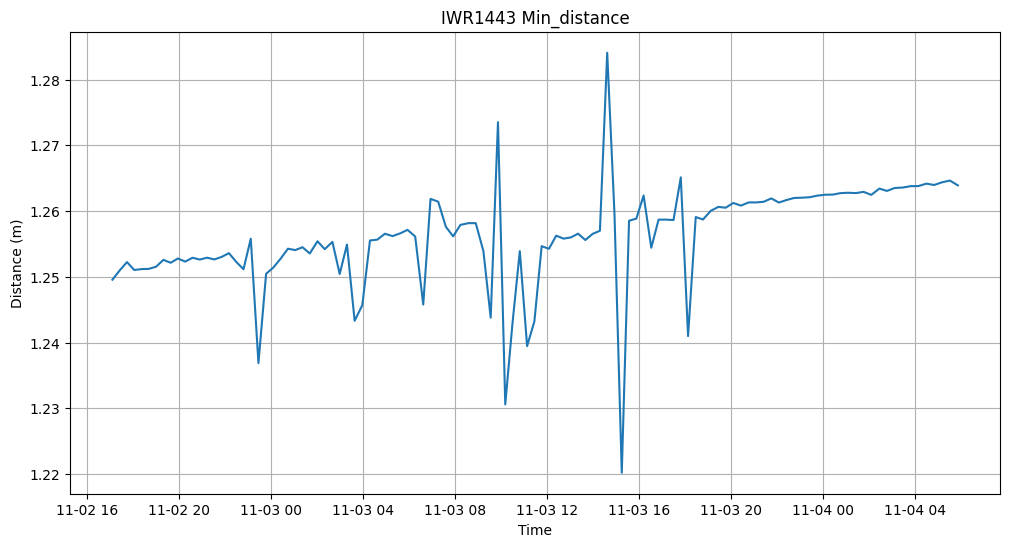

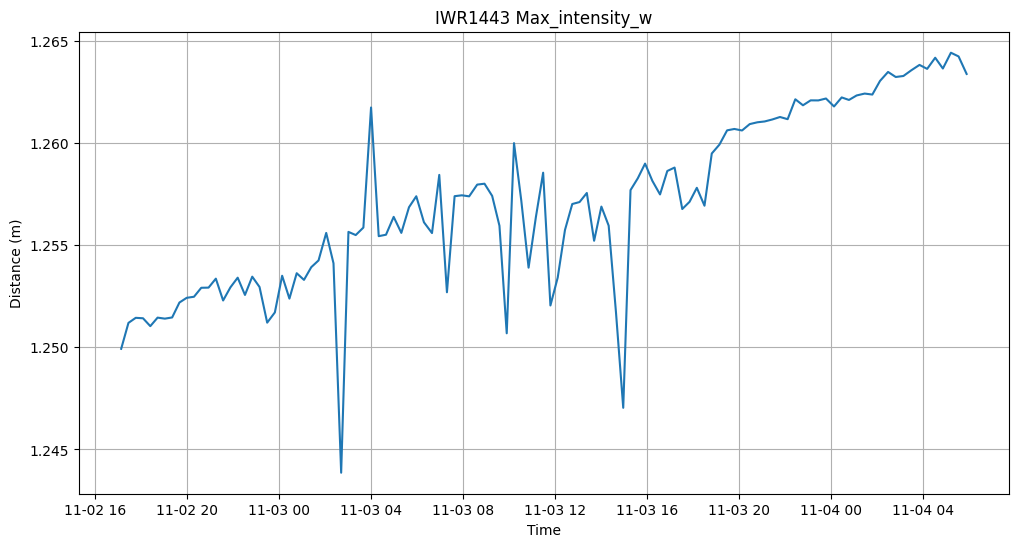

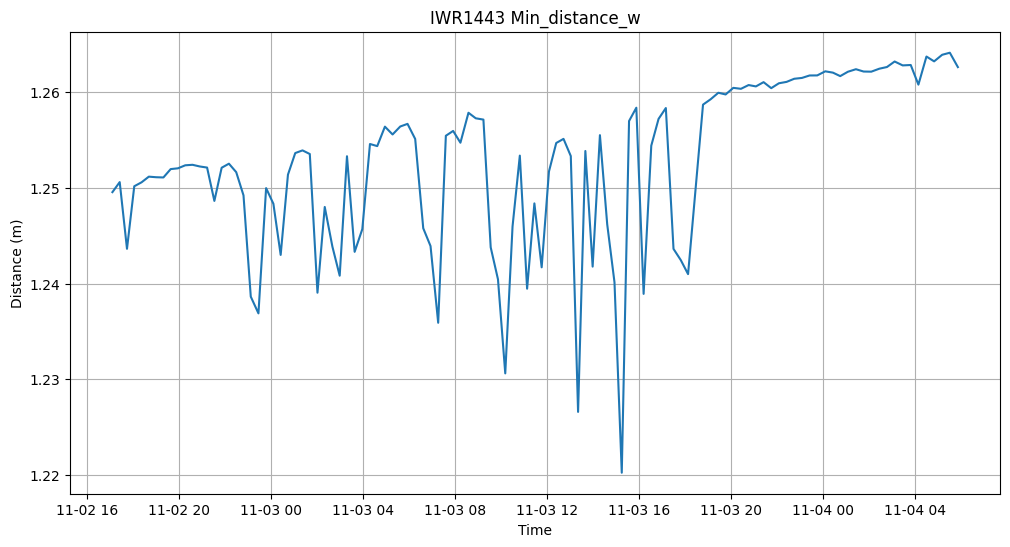

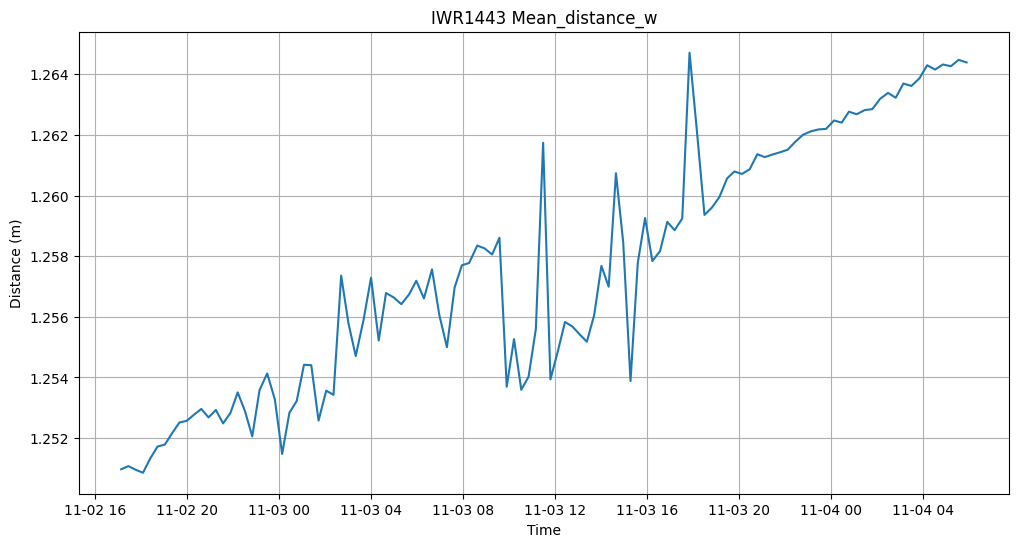

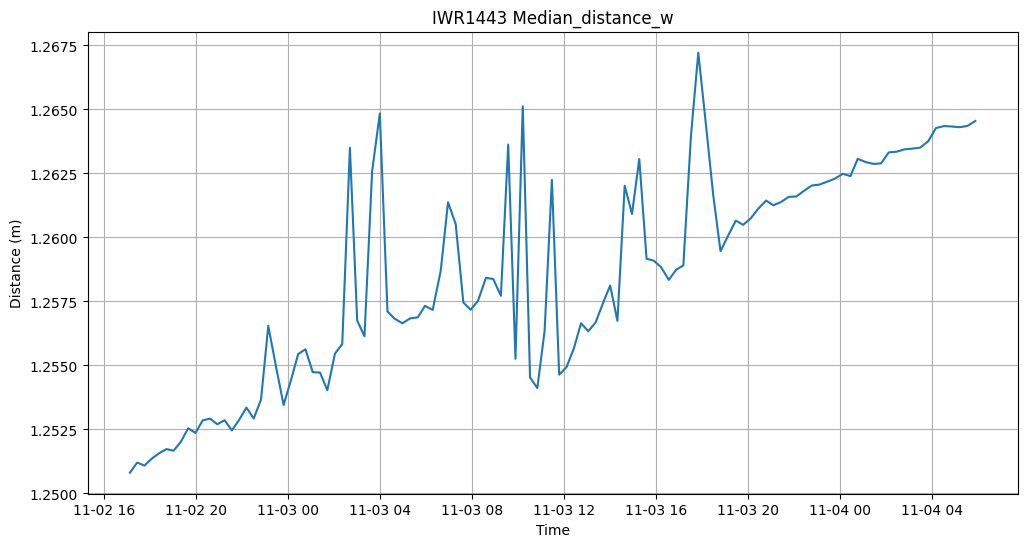

In [18]:
plot.stat_all_runs(dates, iwr1443_stats, sensor_name='iwr1443')

## Param Search

In [19]:
# scores = utils.param_search(iwr1443, gt_depths_matched, 'iwr1443')
with open("iwr1443_params.pkl", "rb") as f:
    scores = pickle.load(f)

best_scores = utils.get_best_scores(scores)
utils.print_unique_score_params(best_scores)

y_threshold: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
y_limit: [10, 15, 20, 50]
x_limit: [0.2, 0.5, 1]
intensity_threshold_percent: [0, 5, 10, 25, 50, 75, 90]
window_size: [100]
stat_name: ['mean_distance_w']
mse: [np.float64(1.0052161495477015e-05)]


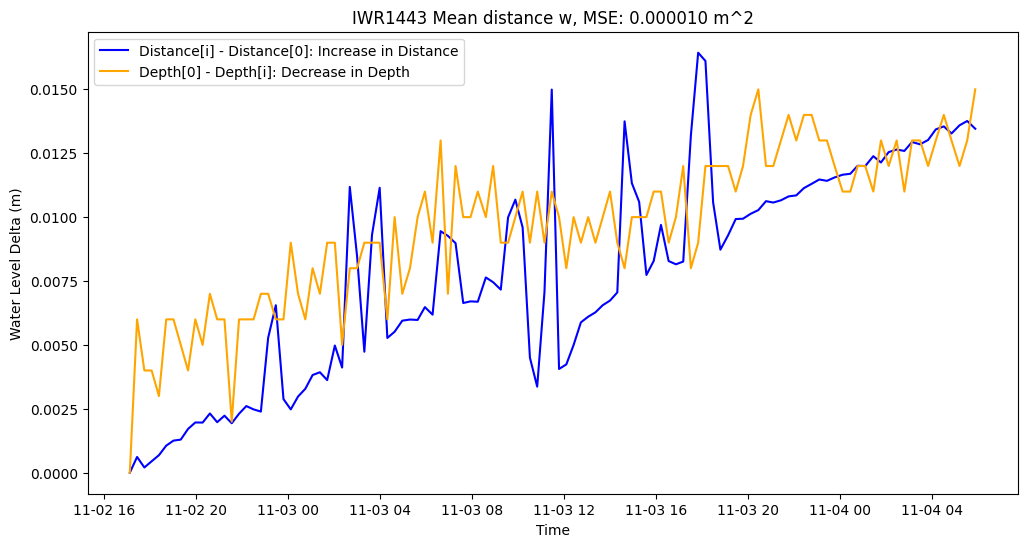

In [20]:
iwr1443_filtered_final = utils.filter_points(iwr1443, y_threshold=0.0, y_limit=50, x_limit=1, intensity_threshold_percent=90)
iwr1443_stats_final = utils.compute_statistics(iwr1443_filtered_final, window_size=100)
plot.plot_deltas(dates, iwr1443_stats_final['mean_distance_w'], gt_depths_matched, 'mean_distance_w', 'iwr1443')

### No Filter

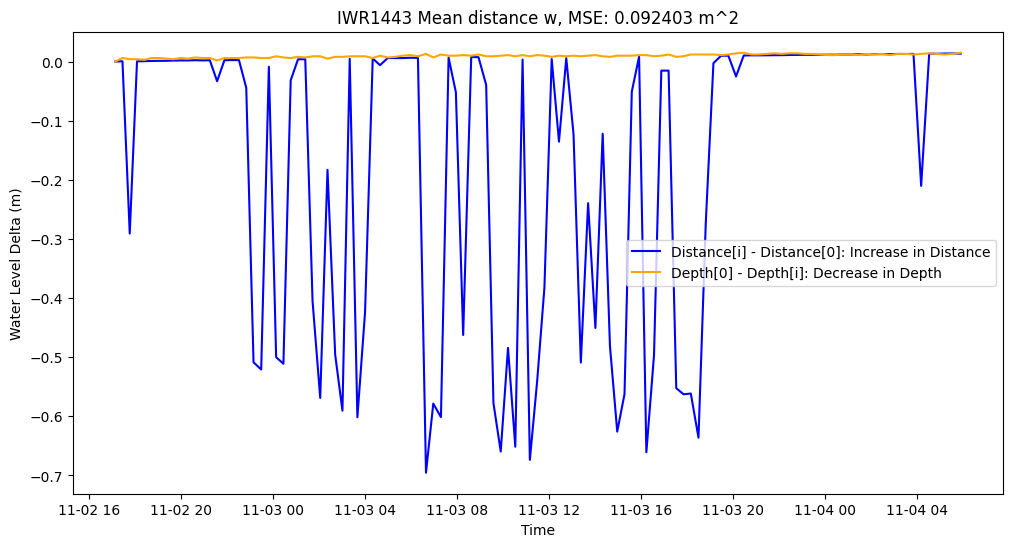

In [21]:
iwr1443_stats_final = utils.compute_statistics(iwr1443, window_size=100)
plot.plot_deltas(dates, iwr1443_stats_final['mean_distance_w'], gt_depths_matched, 'mean_distance_w', 'iwr1443')

### Smaller Window

In [22]:
# scores_smallw = utils.param_search_smallw(iwr1443, gt_depths_matched, 'iwr1443')
with open("iwr1443_params_smallw.pkl", "rb") as f:
    scores_smallw = pickle.load(f)

best_scores_smallw = utils.get_best_scores(scores_smallw)
utils.print_unique_score_params(best_scores_smallw)

y_threshold: [0.0, 0.1, 0.5]
y_limit: [10, 15, 20, 50]
x_limit: [0.2, 0.5, 1]
intensity_threshold_percent: [0, 5, 10, 25, 50, 75, 90]
window_size: [15]
stat_name: ['median_distance_w']
mse: [np.float64(8.640137308252706e-06)]


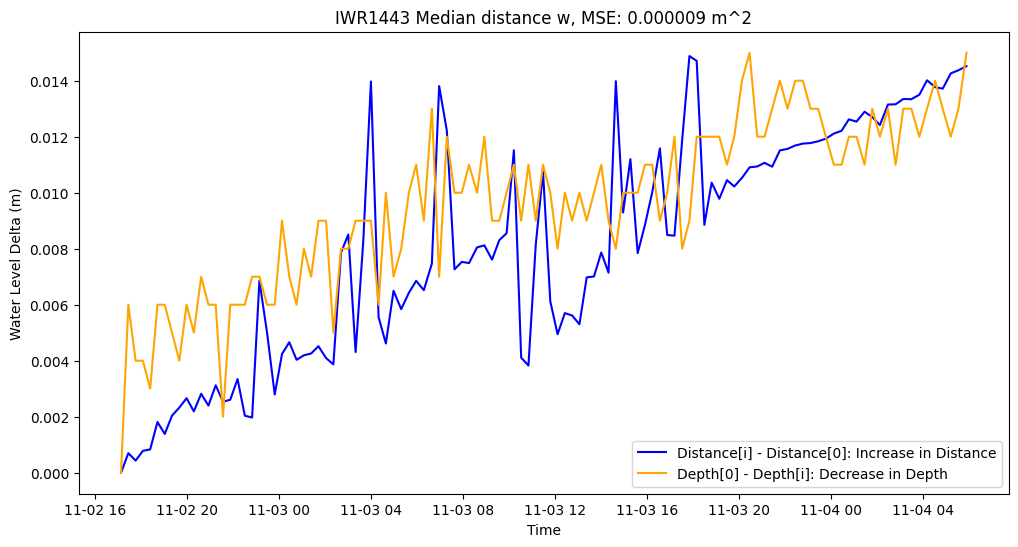

In [23]:
iwr1443_filtered_final = utils.filter_points(iwr1443, y_threshold=0.0, y_limit=50, x_limit=1, intensity_threshold_percent=90)
iwr1443_stats_final = utils.compute_statistics(iwr1443_filtered_final, window_size=15)
plot.plot_deltas(dates, iwr1443_stats_final['median_distance_w'], gt_depths_matched, 'median_distance_w', 'iwr1443')

### Limited Max Measurements

In [24]:
# scores_limited_measurements = utils.param_search_limited_measurements(iwr1443, gt_depths_matched, 'iwr1443')
with open("iwr1443_params_limited_measurements.pkl", "rb") as f:
    scores_limited_measurements = pickle.load(f)

best_scores_limited_measurements = utils.get_best_scores(scores_limited_measurements)
utils.print_unique_score_params(best_scores_limited_measurements)

y_threshold: [0.0, 0.1]
y_limit: [25, 50, 100]
x_limit: [1, 2]
intensity_threshold_percent: [50, 75, 90]
window_size: [5]
max_measurements: [25]
stat_name: ['mean_distance_w']
mse: [np.float64(7.80178798968624e-06)]


In [25]:
utils.print_unique_score_params(list(filter(lambda score: score['x_limit'] == 2 and score['y_limit'] == 100, best_scores_limited_measurements)))

y_threshold: [0.1]
y_limit: [100]
x_limit: [2]
intensity_threshold_percent: [50, 75, 90]
window_size: [5]
max_measurements: [25]
stat_name: ['mean_distance_w']
mse: [np.float64(7.80178798968624e-06)]


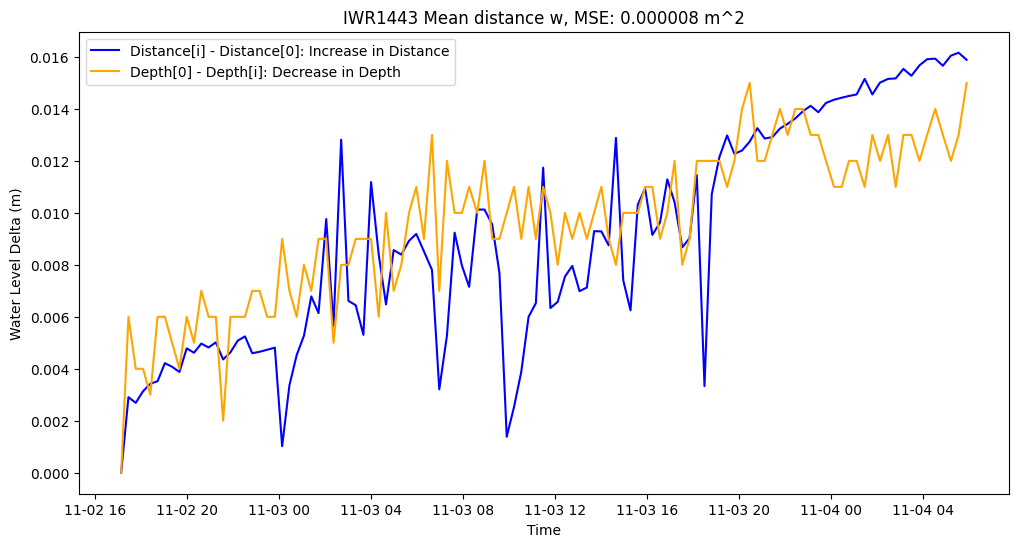

In [26]:
iwr1443_filtered_final = utils.filter_points(iwr1443, y_threshold=0.1, y_limit=100, x_limit=2, intensity_threshold_percent=50)
iwr1443_stats_final = utils.compute_statistics(iwr1443_filtered_final, window_size=5)
plot.plot_deltas(dates, iwr1443_stats_final['mean_distance_w'], gt_depths_matched, 'mean_distance_w', 'iwr1443', max_measurements=25)

In [27]:
utils.calc_delta_mse(iwr1443_stats_final['mean_distance_w'], gt_depths_matched, max_measurements=25)

np.float64(7.80178798968624e-06)

### Window Size search
1) No Filter

In [28]:
scores_window_size_nofilter = utils.window_size_search(iwr1443, gt_depths_matched, 'iwr1443')
best_scores_window_size_nofilter = utils.get_best_scores(scores_window_size_nofilter)
utils.print_unique_score_params(best_scores_window_size_nofilter)

window_size: [200]
max_measurements: [25]
stat_name: ['median_distance_w']
mse: [np.float64(0.01221250046198031)]


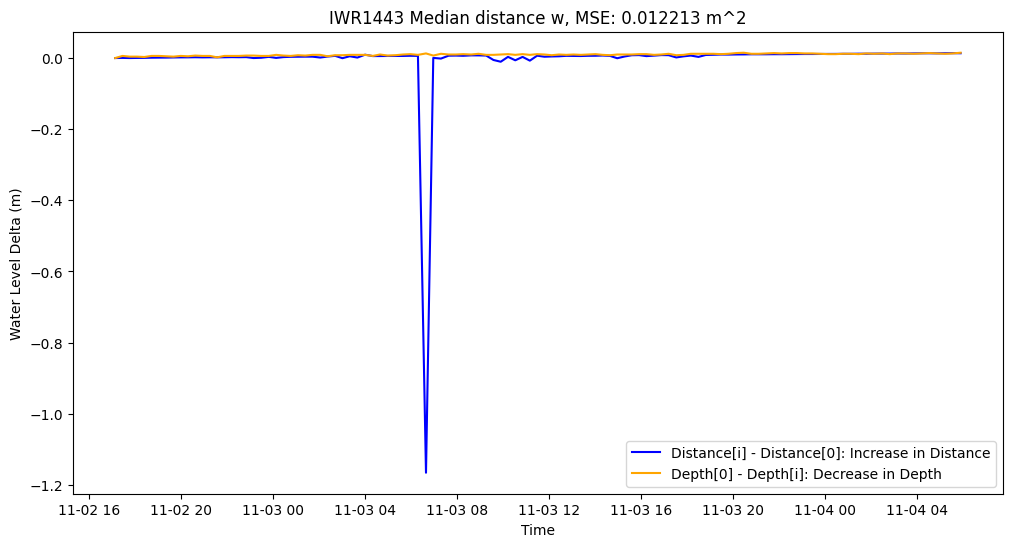

In [29]:
iwr1443_stats_no_filter = utils.compute_statistics(iwr1443, window_size=200)
plot.plot_deltas(dates, iwr1443_stats_no_filter['median_distance_w'], gt_depths_matched, 'median_distance_w', 'iwr1443', max_measurements=25)

In [30]:
iwr1443_results_no_filter = utils.calc_distance_per_run(iwr1443_stats_no_filter['median_distance_w'], max_measurements=25)

2) Relaxed Filter

In [31]:
iwr1443_relaxed_filter = utils.filter_points(iwr1443, y_threshold=0.1, x_limit=2)
scores_window_size_relaxed = utils.window_size_search(iwr1443_relaxed_filter, gt_depths_matched, 'iwr1443')
best_scores_window_size_relaxed = utils.get_best_scores(scores_window_size_relaxed)
utils.print_unique_score_params(best_scores_window_size_relaxed)

/home/arpg/projects/radar-water-monitoring/src/data_utils.py:142: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sensor_modes = np.array([scipy_stats.mode(y[:max_measurements], keepdims=False).mode for y in sensor_stat])


window_size: [5]
max_measurements: [25]
stat_name: ['mean_distance_w']
mse: [np.float64(7.80178798968624e-06)]


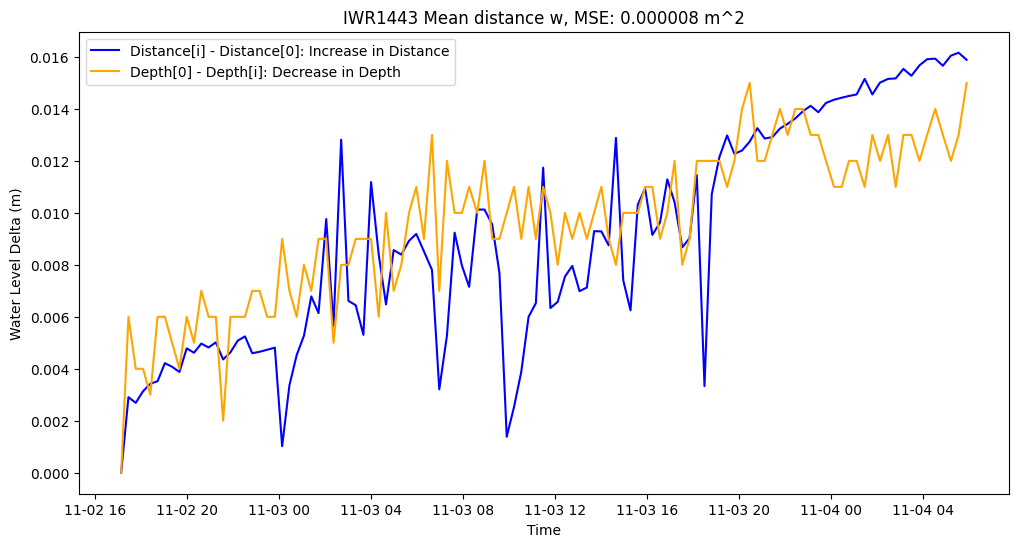

In [32]:
iwr1443_stats_relaxed_filter = utils.compute_statistics(iwr1443_relaxed_filter, window_size=5)
plot.plot_deltas(dates, iwr1443_stats_relaxed_filter['mean_distance_w'], gt_depths_matched, 'mean_distance_w', 'iwr1443', max_measurements=25)

In [33]:
iwr1443_results_relaxed_filter = utils.calc_distance_per_run(iwr1443_stats_no_filter['mean_distance_w'], max_measurements=25)

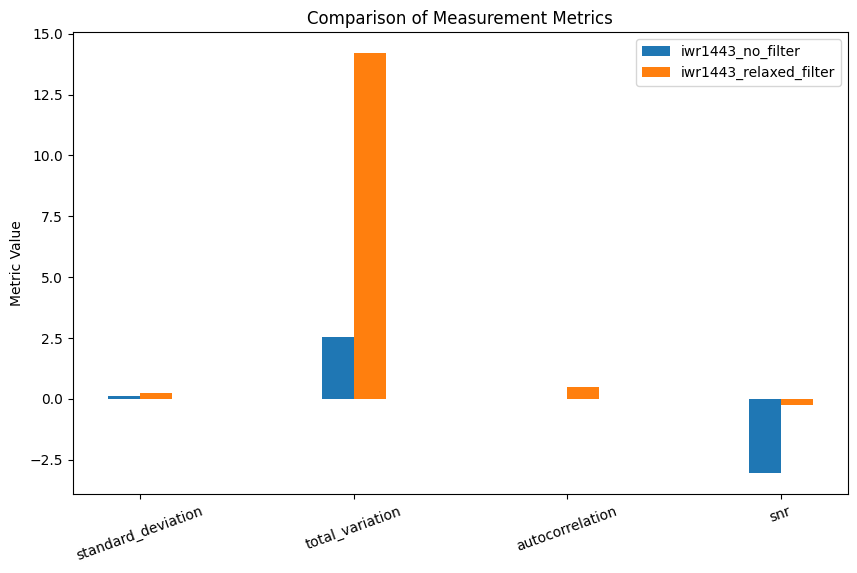

{'iwr1443_no_filter': {'standard_deviation': np.float64(0.10935221339088265),
  'total_variation': np.float64(2.536515712738037),
  'autocorrelation': np.float64(-0.0029634366808294343),
  'snr': np.float64(-3.060873426411371)},
 'iwr1443_relaxed_filter': {'standard_deviation': np.float64(0.21812428651141708),
  'total_variation': np.float64(14.198718905448914),
  'autocorrelation': np.float64(0.4721796743634395),
  'snr': np.float64(-0.24265263725189956)}}

In [34]:
plot.compare_metrics([
        iwr1443_results_no_filter,
        iwr1443_results_relaxed_filter
    ], labels=['iwr1443_no_filter', 'iwr1443_relaxed_filter'], autocorrelation_lag=1
)

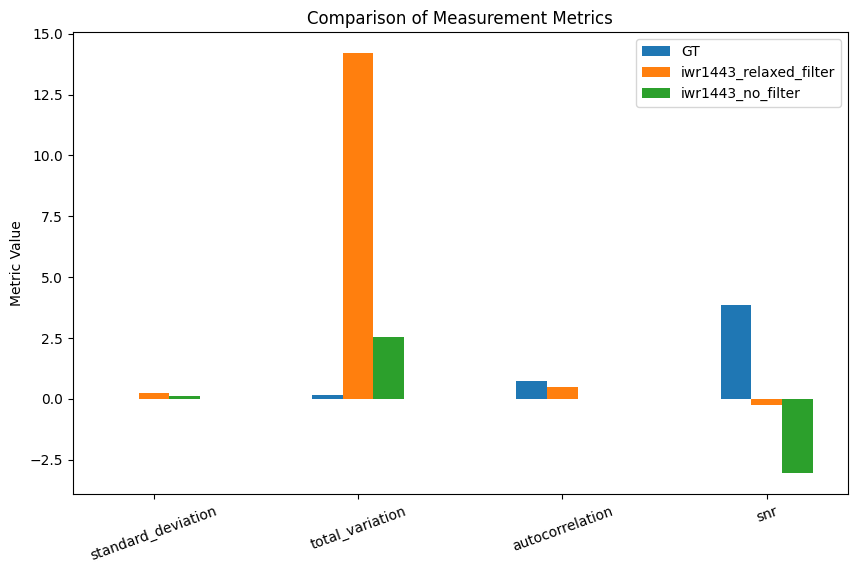

{'GT': {'standard_deviation': np.float64(0.0029677656777249853),
  'total_variation': np.float64(0.16100000000000014),
  'autocorrelation': np.float64(0.7350788909651821),
  'snr': np.float64(3.8620495451792323)},
 'iwr1443_relaxed_filter': {'standard_deviation': np.float64(0.21812428651141708),
  'total_variation': np.float64(14.198718905448914),
  'autocorrelation': np.float64(0.47217967436343955),
  'snr': np.float64(-0.24265263725189956)},
 'iwr1443_no_filter': {'standard_deviation': np.float64(0.10935221339088265),
  'total_variation': np.float64(2.536515712738037),
  'autocorrelation': np.float64(-0.0029634366808294335),
  'snr': np.float64(-3.060873426411371)}}

In [35]:
d1, gt_d1 = utils.calc_deltas(iwr1443_results_relaxed_filter, gt_depths_matched)
d2, _ = utils.calc_deltas(iwr1443_results_no_filter, gt_depths_matched)

plot.compare_metrics([
        gt_d1, d1, d2
    ], labels=['GT', 'iwr1443_relaxed_filter', 'iwr1443_no_filter'], autocorrelation_lag=1
)